# Resample images to standard grid using a DEM

** replace all DSM with DEM

In [1]:
import rasterio as rio
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from rasterio.warp import reproject, Resampling
from osgeo import gdal
import shutil

### Read in DEM (or any geotiff) that is clipped to the same area as the AOI used to download the images

In [8]:
##############
dempath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/forAutoRIFT/IfSAR_DSM_5m_cropped.tif'
##############

In [20]:
dsm = rio.open(dempath) # open using rasterio
elev = dsm.read(1) # read in the first and only band (elevations)
dsm_resolution = dsm.transform[0]
print(dsm_resolution)

4.979215071770336


### Grab the spatial information (that the images will be standardized to)

In [10]:
# grab the x and y grid values for the DSM
dsm_x = np.linspace(dsm.bounds.left, dsm.bounds.right, num=np.shape(elev)[1])
dsm_y = np.linspace(dsm.bounds.top, dsm.bounds.bottom, num=np.shape(elev)[0])

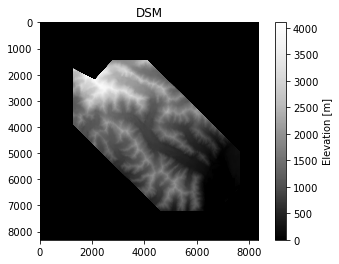

In [11]:
# Display the DSM
fig, ax1 = plt.subplots(1,1)
hs_im = ax1.imshow(elev, cmap='Greys_r', vmin=0)
ax1.set_title('DSM')
# ax1.set_xlabel('Easting [m]')
# ax1.set_ylabel('Northing [m]')
fig.colorbar(hs_im, ax=ax1,label='Elevation [m]')
plt.show()

### Interpolate 1 image to DEM grid

In [13]:
imgpath = '/Volumes/LaCie/PS_downloads_SK/download/PSScene/' # path to a test image
imgname = '20200302_204101_19_105a_3B_AnalyticMS_SR_harmonized_clip.tif' # image filename

# create a folder to place the reprojected files
if not os.path.exists(imgpath + 'reprojected/'):
    os.mkdir(imgpath + 'reprojected/')

raster = gdal.Open(imgpath + imgname)
projstg = raster.GetProjection()
imgcrs = projstg.split('EPSG')[-1][3:8]
print(imgcrs)
print(dsm.crs)

# reproject the image into the coordinate system of the DEM
if 'EPSG:' + imgcrs != str(dsm.crs):
    gdal.Warp(imgpath + 'reprojected/' + imgname, imgpath + imgname, dstSRS=str(dsm.crs))
    print('reprojecting' + imgname)
else:
    shutil.copy(imgpath + imgname, imgpath + 'reprojected/'+ imgname)

img = rio.open(imgpath+'reprojected/'+imgname) # open using rasterio
img_data = img.read() # grab the NIR band, 4

print(len(img_data))
if len(img_data) == 4:
    nir = img_data[3]
elif len(img_data) == 1:
    nir = img_data[0]

print("Image dimensions:",nir.shape)
# grab the x and y grid values for the DSM
img_x = np.linspace(img.bounds.left, img.bounds.right, num=np.shape(nir)[1])
img_y = np.linspace(img.bounds.top, img.bounds.bottom, num=np.shape(nir)[0])

32607
EPSG:32607
4
Image dimensions: (6180, 9557)


In [15]:
f = interp2d(img_x, img_y, nir) # create img interpolation object
nir_resamp = np.zeros(np.shape(elev)) # initialize resampled image with DSM shape
nir_resamp = f(dsm_x,dsm_y) # resample the NIR data to the DSM coordinates
nir_resamp = np.flipud(nir_resamp) # flip up down
print("Resample to DSM dimensions:",elev.shape)

Resample to DSM dimensions: (8317, 8360)


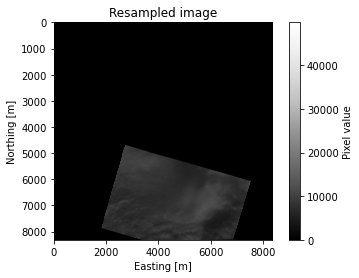

In [16]:
# Display the resampled image
fig, ax1 = plt.subplots(1,1)
plot = ax1.imshow(nir_resamp, cmap='Greys_r')
ax1.set_title('Resampled image')
ax1.set_xlabel('Easting [m]')
ax1.set_ylabel('Northing [m]')
fig.colorbar(plot, ax=ax1,label='Pixel value')
plt.show()

In [22]:
# save the resampled image to georeferenced tif file
outfile = imgname[:-4]+'_'+str(round(dsm_resolution))+'m.tif' # generate new filename with 5m suffix
print("Save resampled image to", outfile)
with rio.open(imgpath+outfile,'w',
                  driver='GTiff',
                  height=nir_resamp.shape[0],
                  width=nir_resamp.shape[1],
                  dtype=nir_resamp.dtype,
                  count=1,
                  crs=dsm.crs,
                  transform=dsm.transform) as dst:
        dst.write(nir_resamp, 1)

Save resampled image to 20200302_204101_19_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif


# Standardize all images in a folder to the DEM

20200314_173229_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2790, 1700)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_173229_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_173229_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 31006.262645446117


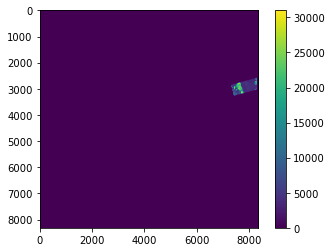

20200304_203531_13_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1429, 3452)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_203531_13_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_203531_13_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 9722.561006702366


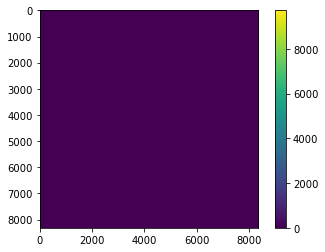

20200314_173228_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4101, 1074)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_173228_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_173228_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 26306.47546437726


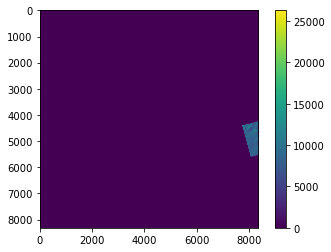

20200311_201002_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4952, 1139)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_201002_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_201002_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23593.0555714318


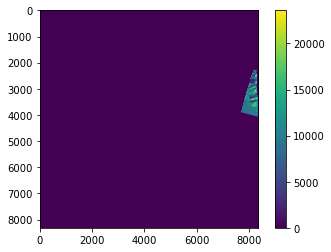

20200314_173227_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4535, 629)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_173227_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_173227_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19750.500731319924


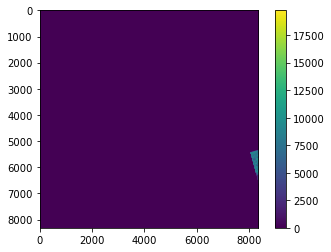

20200317_201017_100a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4962, 1538)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_201017_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_201017_100a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10092.748808757817


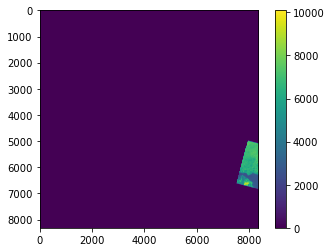

20200315_200934_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1305, 1006)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_200934_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_200934_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17899.62093979183


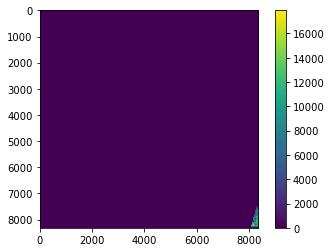

20200312_192208_09_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (540, 7931)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_192208_09_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_192208_09_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20031.24705735698


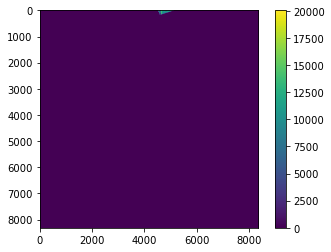

20200303_204228_95_1058_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (421, 6244)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_204228_95_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_204228_95_1058_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16479.85568634851


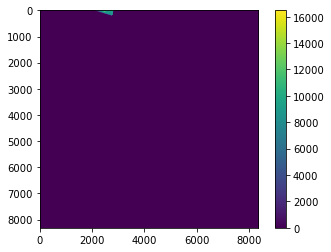

20200315_200933_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3724, 362)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_200933_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_200933_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16234.061970624152


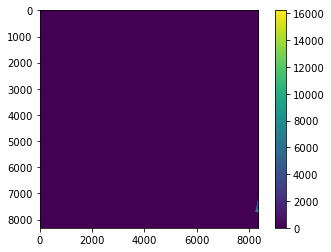

20200314_173231_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3130, 2732)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_173231_0f2e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_173231_0f2e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 34010.11013979124


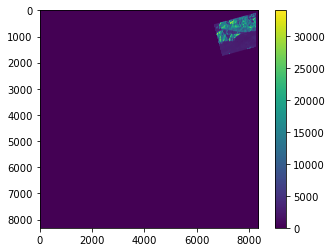

20200301_192304_14_106f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (670, 5135)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200301_192304_14_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200301_192304_14_106f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11701.478691222906


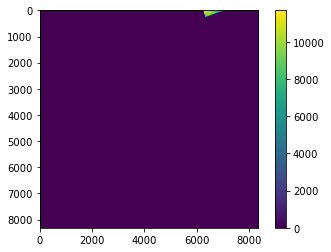

20200302_204055_04_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1413, 6727)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_204055_04_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_204055_04_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10207.655776628046


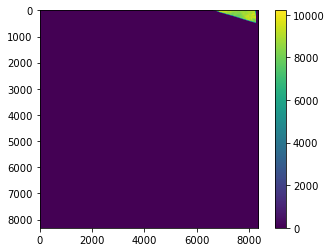

20200311_192921_53_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5274, 1965)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_192921_53_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_192921_53_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21792.7846324877


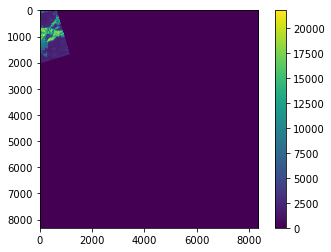

20200311_201003_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4986, 1844)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_201003_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_201003_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22879.766914283326


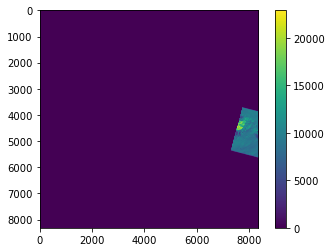

20200317_192533_26_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1982, 6050)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_192533_26_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_192533_26_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14632.838854290409


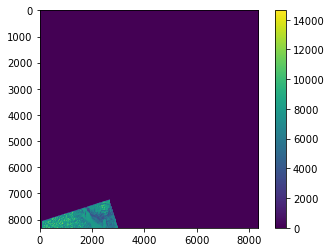

20200311_200118_0e26_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4922, 3787)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_200118_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_200118_0e26_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 25938.48521437701


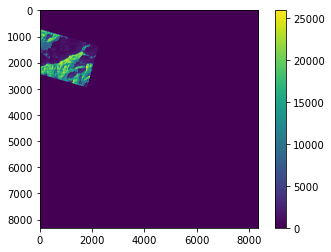

20200311_200117_0e26_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2572, 4474)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_200117_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_200117_0e26_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 24442.02830607889


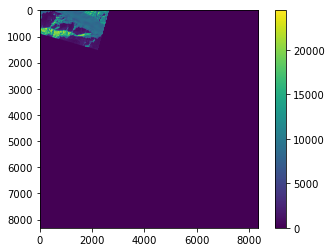

20200307_192644_21_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6366, 149)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200307_192644_21_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200307_192644_21_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8001.926580578296


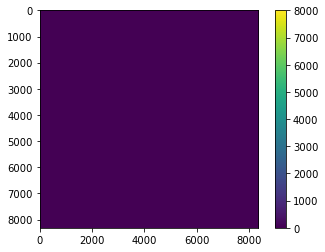

20200311_201004_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4988, 2534)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_201004_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_201004_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20575.14347470843


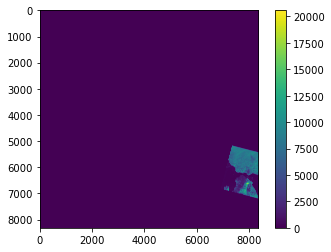

20200311_200122_0e26_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3061, 949)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_200122_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_200122_0e26_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17379.46152609461


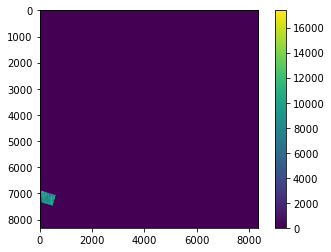

20200312_201604_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (92, 4522)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201604_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201604_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 0.0


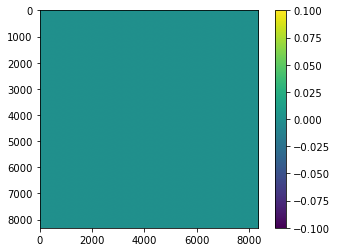

20200330_192458_96_1065_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1820, 5787)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_192458_96_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_192458_96_1065_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15646.723126090688


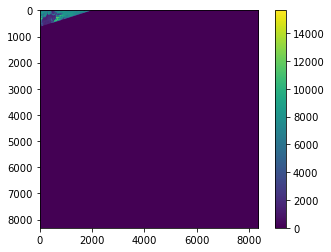

20200301_192257_98_106f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7536, 901)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200301_192257_98_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200301_192257_98_106f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14482.968432252192


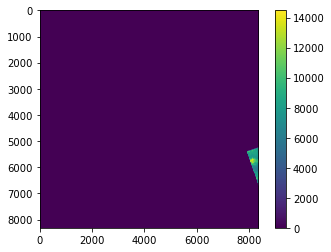

20200311_201001_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4966, 397)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_201001_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_201001_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 24018.19168593166


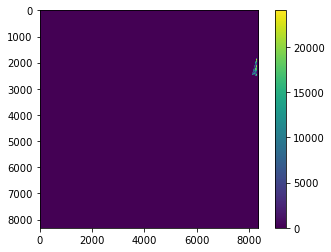

20200303_204235_06_1058_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7308, 2484)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_204235_06_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_204235_06_1058_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20763.72677733086


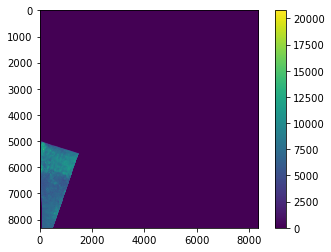

20200311_201005_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2780, 3172)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_201005_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_201005_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23082.564920734847


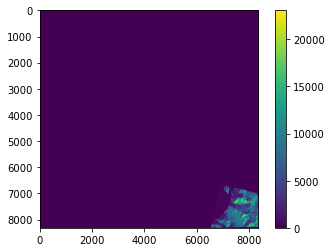

20200311_200116_0e26_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (228, 5157)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_200116_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_200116_0e26_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20711.874358810794


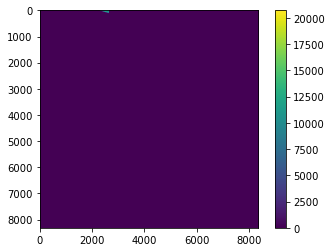

20200311_201006_1008_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (359, 3808)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_201006_1008_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_201006_1008_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19174.535980777295


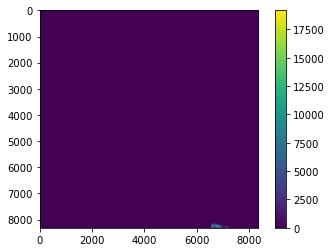

20200317_201016_100a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4949, 826)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_201016_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_201016_100a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10151.883994875825


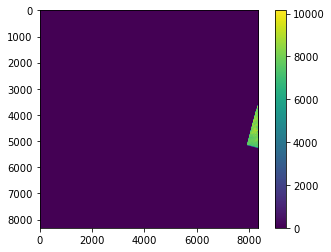

20200315_201749_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2907, 2973)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_201749_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_201749_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15553.765974322654


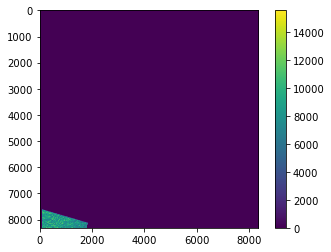

20200307_192642_16_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1678, 1599)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200307_192642_16_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200307_192642_16_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8093.545800246564


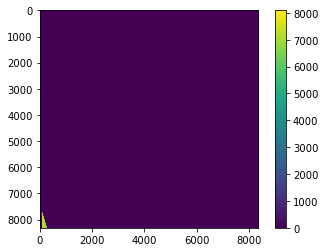

20200330_172810_0f2a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3847, 1162)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172810_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172810_0f2a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18238.052720718748


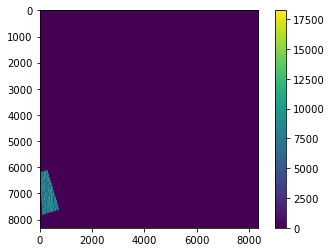

20200319_192624_39_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (320, 9316)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200319_192624_39_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200319_192624_39_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 7075.206896379163


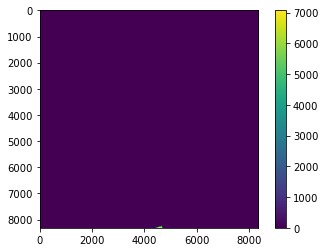

20200315_201747_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5216, 4420)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_201747_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_201747_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18269.472052886467


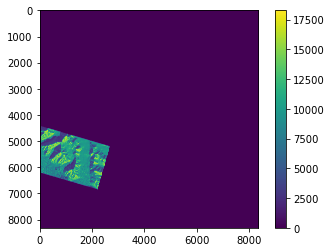

20200312_201557_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2364, 3946)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201557_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201557_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20599.659913030806


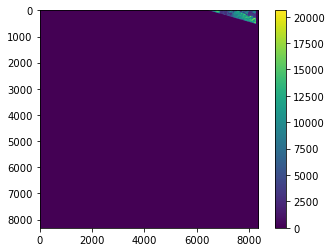

20200318_192601_04_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1246, 9676)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200318_192601_04_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200318_192601_04_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10088.17891579131


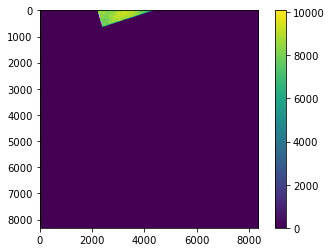

20200317_201847_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5208, 1932)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_201847_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_201847_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16392.62174770547


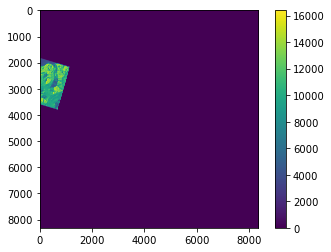

20200319_192632_65_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2766, 3635)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200319_192632_65_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200319_192632_65_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17955.26443837229


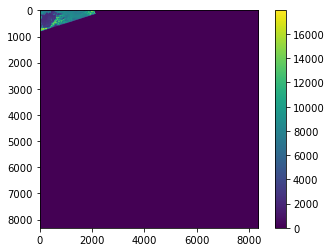

20200314_201145_0f28_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4934, 313)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_201145_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_201145_0f28_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18710.811721068047


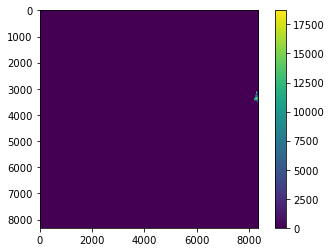

20200324_201449_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5076, 1334)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200324_201449_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200324_201449_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11859.71387034342


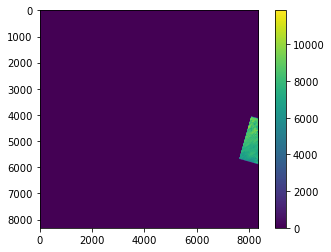

20200308_203623_00_105e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3077, 3362)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200308_203623_00_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200308_203623_00_105e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 9899.380682033232


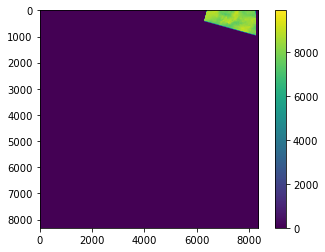

20200319_195420_0e19_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2051, 1423)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200319_195420_0e19_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200319_195420_0e19_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18990.375906358342


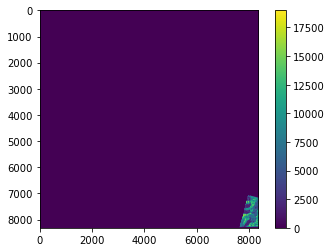

20200326_173534_0f3c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (476, 1798)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_173534_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_173534_0f3c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14684.562292720551


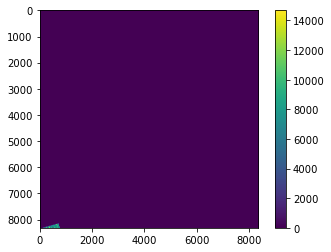

20200330_192450_56_1065_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (955, 9719)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_192450_56_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_192450_56_1065_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 6983.103530105549


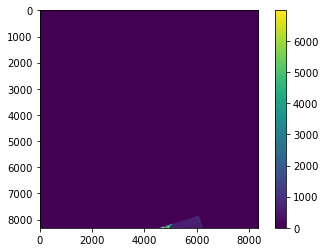

20200326_201141_1006_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4955, 3464)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201141_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201141_1006_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16621.132755652245


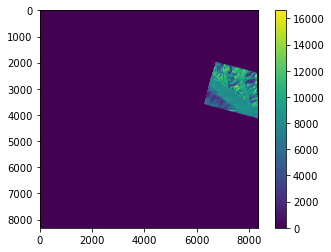

20200326_201139_1006_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3532, 2032)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201139_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201139_1006_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16880.23089561456


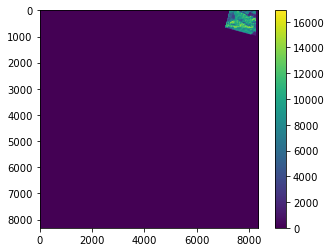

20200328_192356_37_1062_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7882, 350)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200328_192356_37_1062_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200328_192356_37_1062_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16095.572445040605


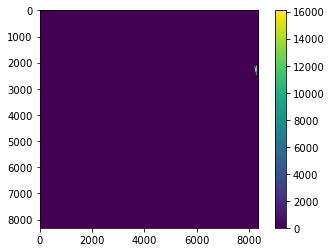

20200317_201019_100a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (679, 2859)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_201019_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_201019_100a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12346.398975817778


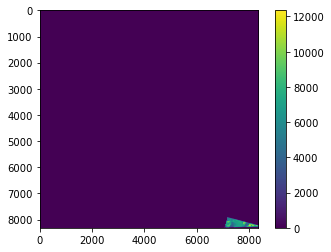

20200324_201448_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5068, 620)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200324_201448_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200324_201448_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14239.02432873362


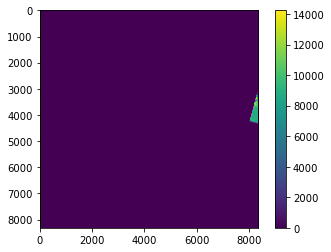

20200326_201839_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1718, 8939)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201839_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201839_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14555.07018548199


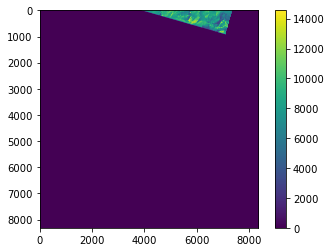

20200328_192358_47_1062_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4261, 1778)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200328_192358_47_1062_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200328_192358_47_1062_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16392.39498066137


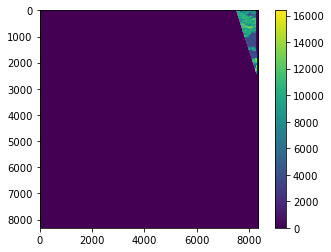

20200325_200931_100a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4930, 2234)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_200931_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_200931_100a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18483.569812706643


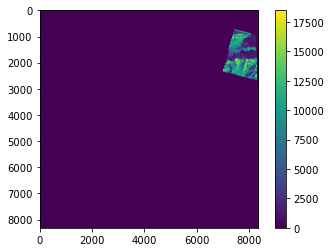

20200322_204124_27_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (398, 8573)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_204124_27_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_204124_27_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11747.016112478721


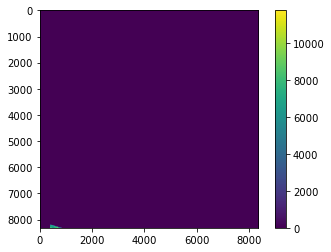

20200317_201848_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5281, 1244)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_201848_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_201848_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15970.738540594528


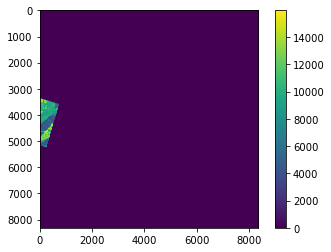

20200328_203802_97_105d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (263, 9498)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200328_203802_97_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200328_203802_97_105d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 6152.3146311794635


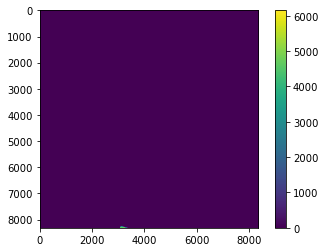

20200304_203523_02_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1431, 9232)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_203523_02_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_203523_02_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 9665.013583868436


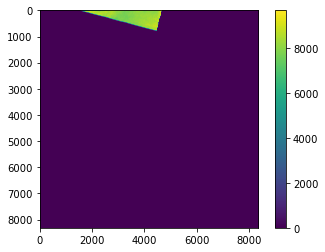

20200325_201753_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2942, 6965)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_201753_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_201753_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16542.196567351028


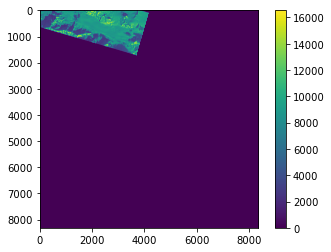

20200317_201018_100a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3090, 2191)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_201018_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_201018_100a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12647.364176601071


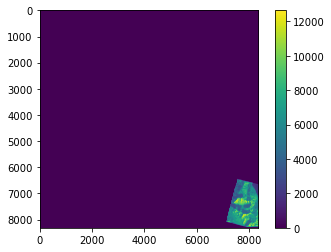

20200325_200930_100a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3869, 1523)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_200930_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_200930_100a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16631.548308685953


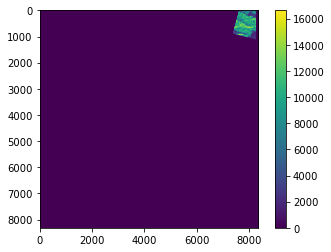

20200324_201450_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4660, 2043)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200324_201450_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200324_201450_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14224.496835981028


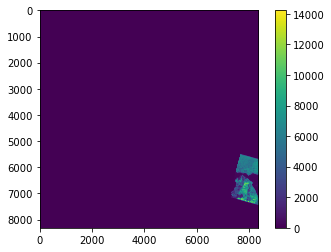

20200326_201146_1006_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1027, 6208)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201146_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201146_1006_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12571.045766939744


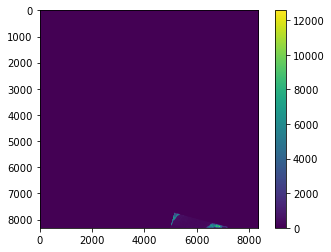

20200326_201846_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (815, 7693)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201846_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201846_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10314.175070794541


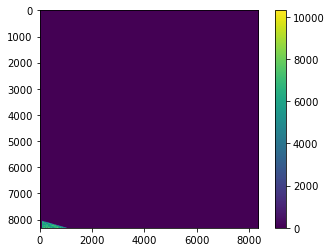

20200317_192539_56_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5651, 1714)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_192539_56_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_192539_56_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11729.150207434253


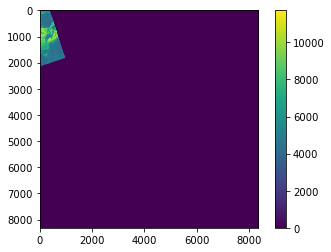

20200302_204103_24_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1528, 9526)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_204103_24_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_204103_24_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10728.979474542883


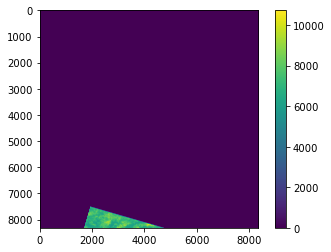

20200320_201520_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (374, 8498)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200320_201520_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200320_201520_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8198.457534976722


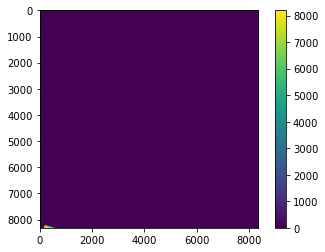

20200318_192552_65_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1642, 5754)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200318_192552_65_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200318_192552_65_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11974.523432428627


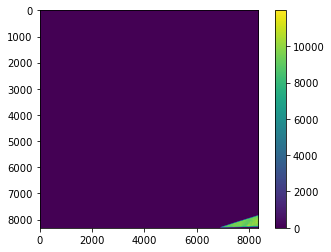

20200323_173029_0f49_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4987, 472)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200323_173029_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200323_173029_0f49_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21183.93982843804


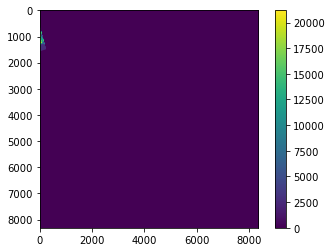

20200326_201143_1006_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4966, 4199)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201143_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201143_1006_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14727.84053979021


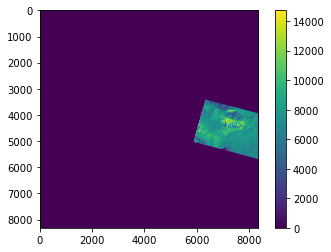

20200315_192405_67_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (445, 9375)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_192405_67_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_192405_67_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12284.129763208439


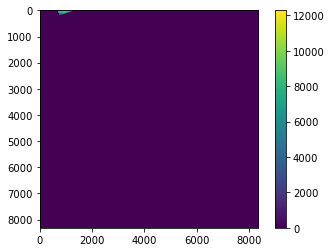

20200316_192429_47_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1884, 9856)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_192429_47_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_192429_47_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8496.615538690616


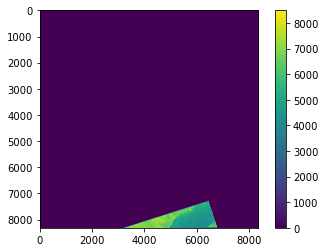

20200326_172809_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2019, 3672)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172809_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172809_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18360.073938885384


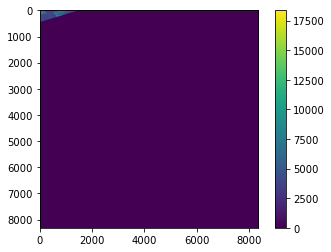

20200302_192327_43_106b_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1763, 5503)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_192327_43_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_192327_43_106b_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 9660.636281391193


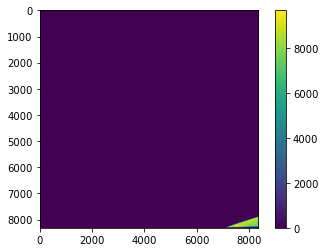

20200312_201603_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2478, 8334)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201603_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201603_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20098.590065422566


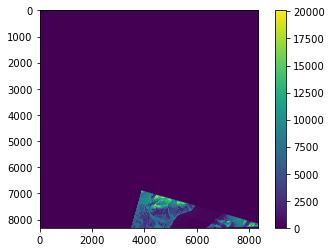

20200326_173536_0f3c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4697, 588)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_173536_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_173536_0f3c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18025.136443598534


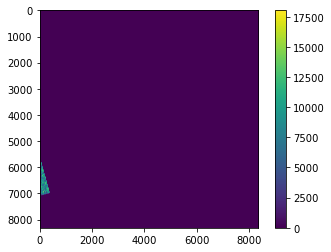

20200316_172913_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2224, 4524)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172913_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172913_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16593.924494165538


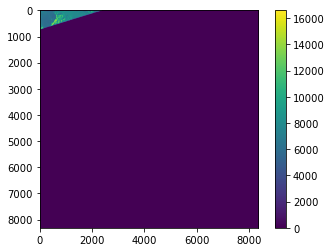

20200322_192824_82_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4687, 914)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_192824_82_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_192824_82_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17456.55169383773


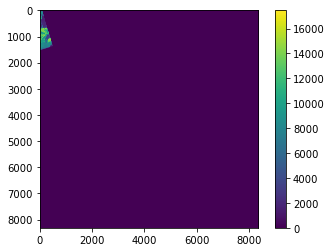

20200315_192357_44_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2927, 8501)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_192357_44_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_192357_44_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17276.73415432685


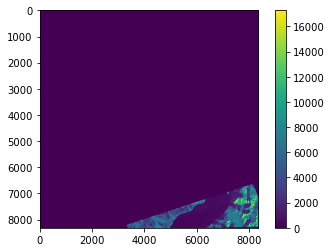

20200327_201624_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (559, 9001)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200327_201624_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200327_201624_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8452.61761328664


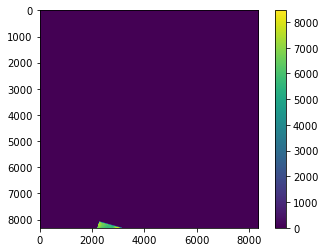

20200326_172802_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1460, 8185)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172802_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172802_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12525.232802122659


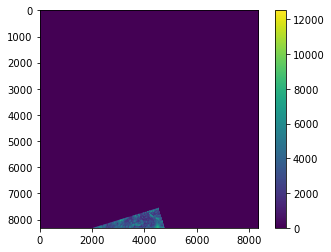

20200311_200120_0e26_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5000, 2350)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_200120_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_200120_0e26_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23771.646331337266


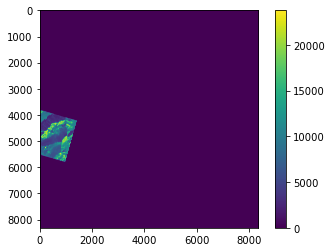

20200301_192300_03_106f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8240, 2352)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200301_192300_03_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200301_192300_03_106f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16175.280451953106


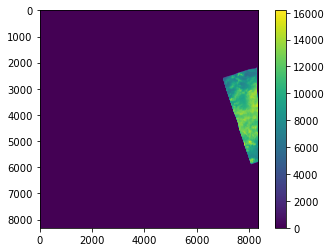

20200316_172907_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1259, 8388)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172907_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172907_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11349.68447961369


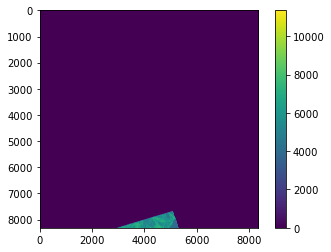

20200327_195953_0e26_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (467, 2677)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200327_195953_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200327_195953_0e26_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8954.537448297358


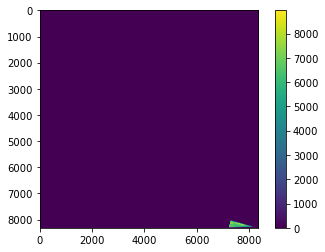

20200330_172809_0f2a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1633, 1792)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172809_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172809_0f2a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15066.97224317457


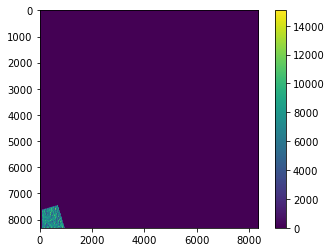

20200325_193031_72_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5642, 516)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_193031_72_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_193031_72_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 13607.165120853446


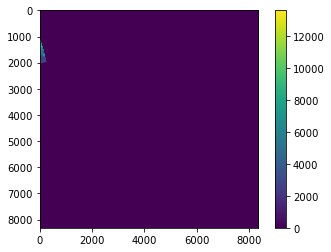

20200330_172811_0f2a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4889, 528)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172811_0f2a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172811_0f2a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15866.762591029652


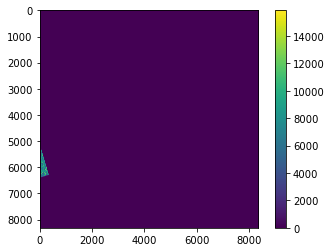

20200315_201748_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5233, 3692)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_201748_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_201748_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16561.933476346938


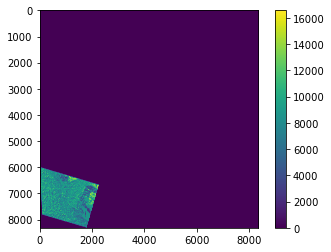

20200315_201744_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4206, 6585)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_201744_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_201744_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21751.939606076106


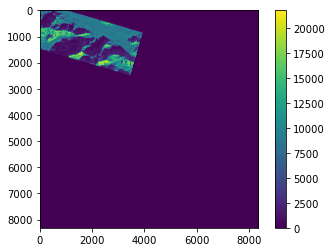

20200315_201745_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5189, 5850)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_201745_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_201745_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22446.83655648948


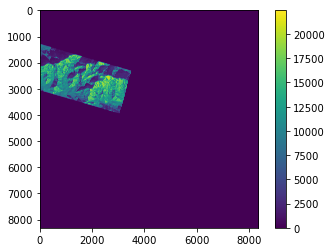

20200312_201558_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4755, 4677)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201558_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201558_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21930.680203355798


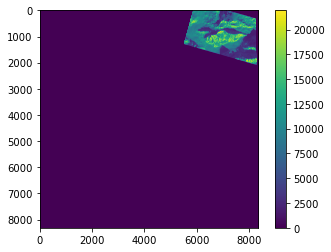

20200315_201743_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1817, 7260)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_201743_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_201743_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19034.19339935769


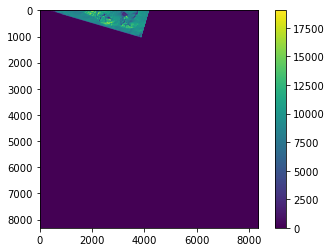

20200314_201150_0f28_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1199, 2962)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_201150_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_201150_0f28_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18405.314356456907


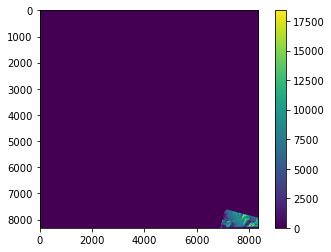

20200312_201219_101f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2180, 9124)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201219_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201219_101f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19751.071426128467


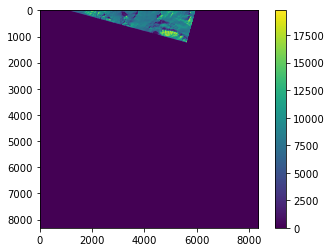

20200329_201729_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2578, 8181)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_201729_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_201729_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 13501.199060558207


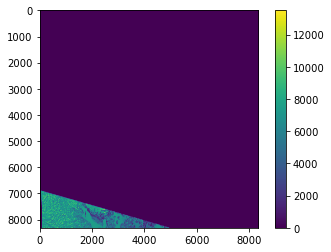

20200312_201559_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5142, 5441)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201559_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201559_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21364.310065583108


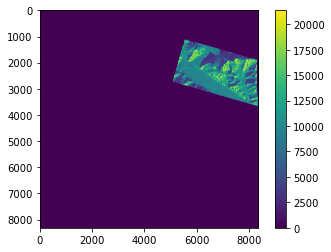

20200311_200119_0e26_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5000, 3060)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_200119_0e26_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_200119_0e26_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23103.354741524552


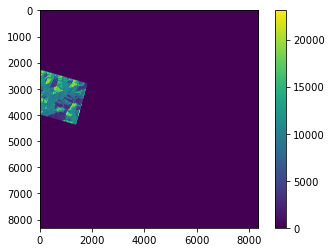

20200306_204115_71_105d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1718, 7485)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200306_204115_71_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200306_204115_71_105d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20919.403124437114


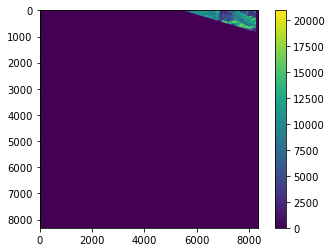

20200326_173535_0f3c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2687, 1192)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_173535_0f3c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_173535_0f3c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16918.89743772382


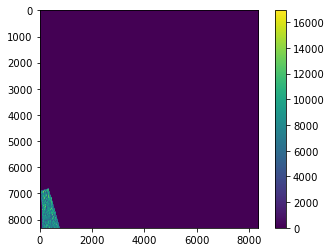

20200316_172913_1_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4429, 5209)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172913_1_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172913_1_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18428.109594501857


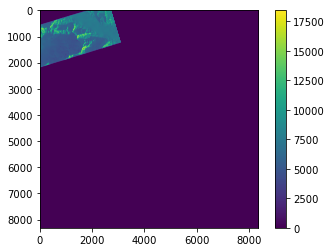

20200311_192919_48_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7980, 3421)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_192919_48_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_192919_48_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22782.660877753995


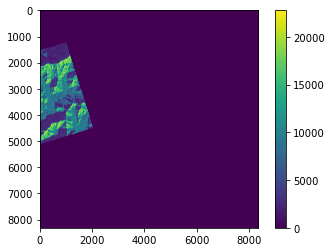

20200314_201148_0f28_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4983, 1697)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_201148_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_201148_0f28_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14595.766583562687


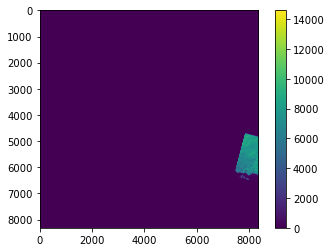

20200317_192535_36_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6759, 4597)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_192535_36_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_192535_36_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14485.632345370468


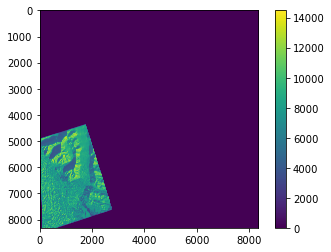

20200312_201226_101f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2426, 6018)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201226_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201226_101f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14821.586641582735


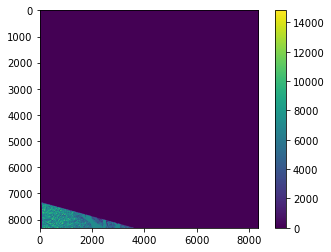

20200313_201357_1012_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1953, 7231)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200313_201357_1012_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200313_201357_1012_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8371.089327852038


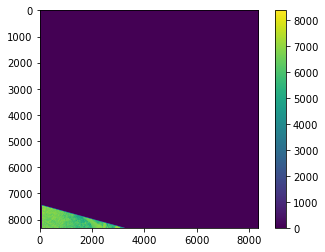

20200313_192302_55_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1956, 5072)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200313_192302_55_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200313_192302_55_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8525.595108279185


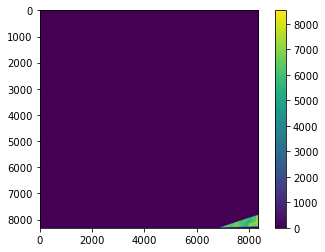

20200316_192437_83_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1149, 6458)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_192437_83_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_192437_83_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 6938.216821759022


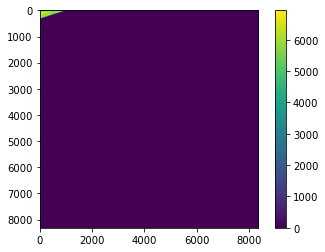

20200316_172910_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4855, 7142)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172910_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172910_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15555.53285530836


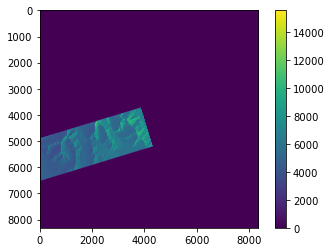

20200304_192444_54_1068_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4919, 6589)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_192444_54_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_192444_54_1068_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14847.328474390753


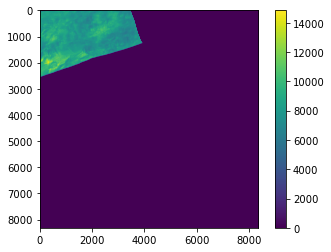

20200314_201147_0f28_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4961, 1013)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_201147_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_201147_0f28_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18627.66793358797


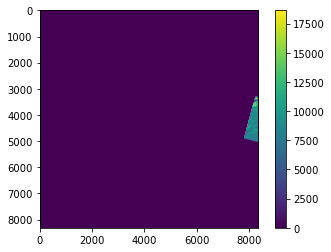

20200315_201746_1032_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5208, 5133)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_201746_1032_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_201746_1032_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18712.309178347732


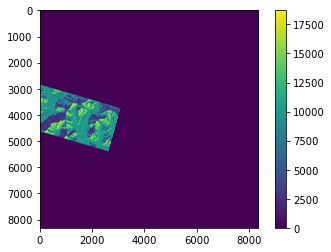

20200312_201600_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5140, 6198)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201600_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201600_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20658.127604053327


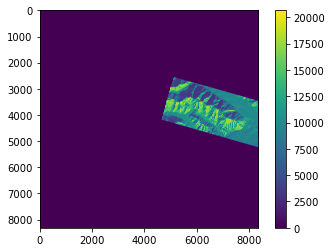

20200316_172909_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4846, 7792)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172909_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172909_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14588.352841058775


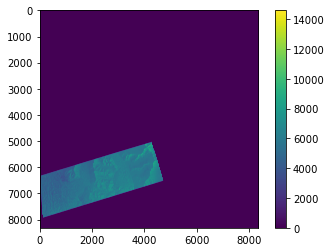

20200330_172428_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2102, 7888)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172428_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172428_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22504.421467240205


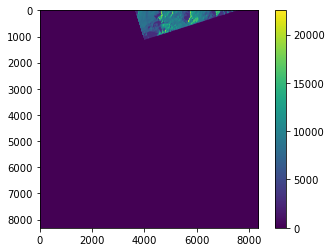

20200312_201225_101f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4857, 6714)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201225_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201225_101f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18632.66029250191


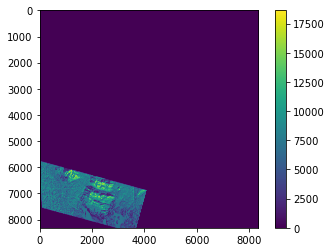

20200323_173026_0f49_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4753, 2958)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200323_173026_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200323_173026_0f49_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22883.89137868579


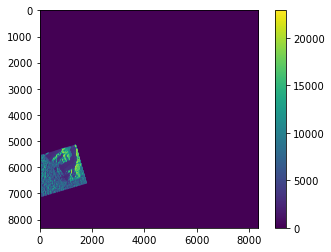

20200312_201222_101f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5026, 8761)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201222_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201222_101f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21594.101301405695


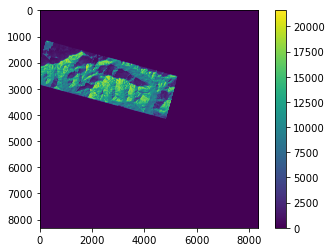

20200317_192537_46_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8080, 3170)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_192537_46_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_192537_46_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14304.79669792085


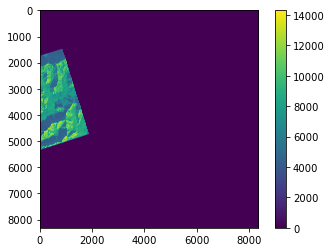

20200330_172422_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3698, 4056)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172422_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172422_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22058.383383648652


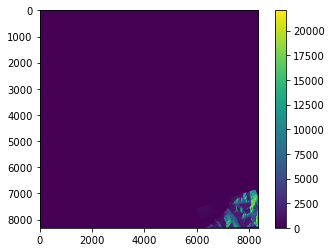

20200302_192335_65_106b_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1938, 10039)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_192335_65_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_192335_65_106b_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11826.555100417281


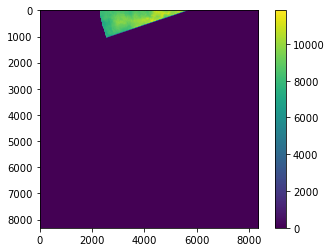

20200314_201149_0f28_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3592, 2354)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200314_201149_0f28_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200314_201149_0f28_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18650.259485109327


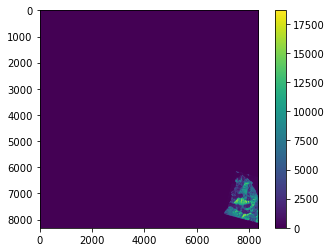

20200305_192542_62_106f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6464, 3980)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200305_192542_62_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200305_192542_62_106f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 27329.479243261892


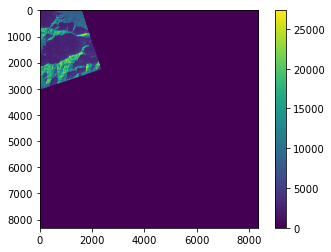

20200312_201602_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4864, 7665)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201602_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201602_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22289.886096712435


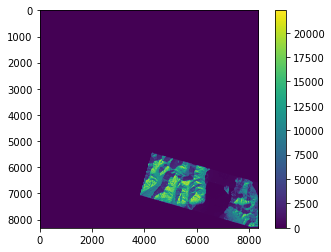

20200323_173029_1_0f49_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5265, 1136)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200323_173029_1_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200323_173029_1_0f49_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22709.908339333462


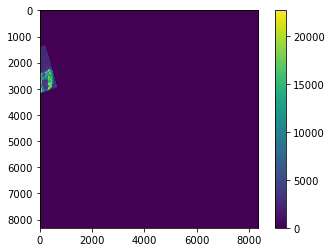

20200312_201221_101f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4592, 9115)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201221_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201221_101f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19987.339081899016


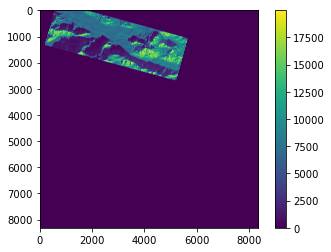

20200304_203529_10_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6009, 4798)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_203529_10_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_203529_10_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16924.958011567294


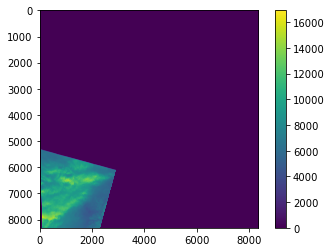

20200316_172912_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4848, 5876)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172912_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172912_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18641.39834733189


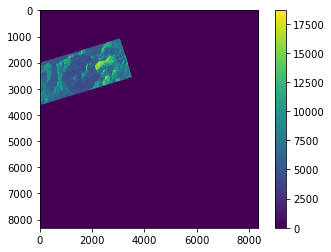

20200323_173028_0f49_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4722, 1595)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200323_173028_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200323_173028_0f49_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23432.421811230706


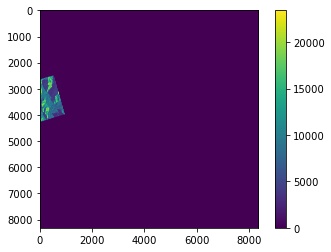

20200329_172820_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3063, 2742)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172820_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172820_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17845.761208214833


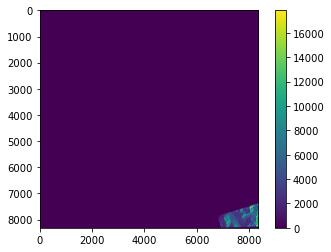

20200326_172808_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4242, 4321)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172808_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172808_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22649.788654602668


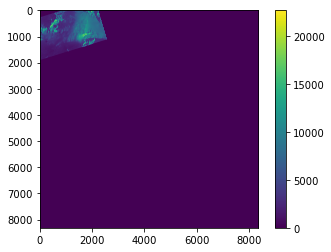

20200312_192201_85_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7528, 3596)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_192201_85_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_192201_85_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19803.95493846667


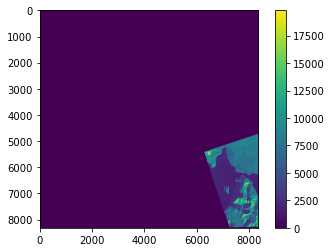

20200324_201451_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2285, 2728)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200324_201451_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200324_201451_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15252.724933803467


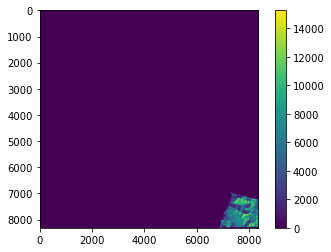

20200320_201513_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2109, 9055)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200320_201513_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200320_201513_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18733.52994952562


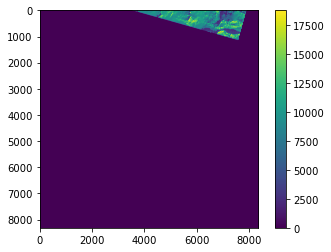

20200329_172826_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (367, 7034)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172826_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172826_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22175.166016872725


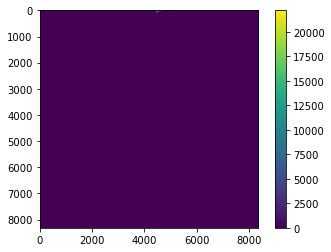

20200329_201723_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2286, 9085)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_201723_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_201723_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16251.14148342038


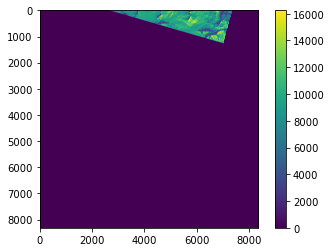

20200303_192406_15_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3714, 9891)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_192406_15_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_192406_15_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14809.55827807756


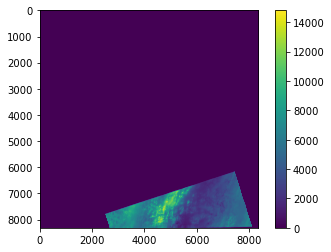

20200313_203931_35_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5256, 4662)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200313_203931_35_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200313_203931_35_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 32472.45091907548


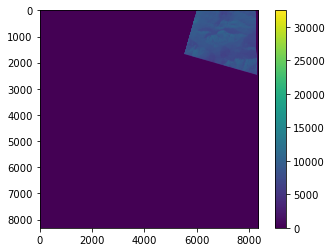

20200325_193029_62_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7817, 1919)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_193029_62_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_193029_62_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14910.160612490228


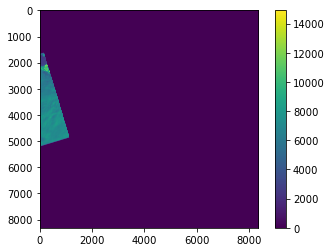

20200324_192923_32_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4127, 1487)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200324_192923_32_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200324_192923_32_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12182.033457176565


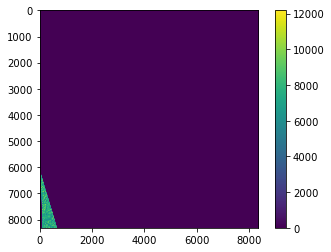

20200320_201519_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2760, 9079)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200320_201519_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200320_201519_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 13404.337329034117


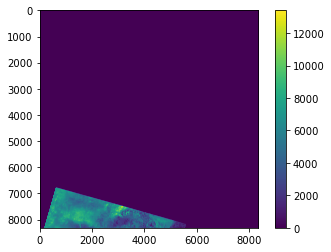

20200304_192438_37_1068_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3418, 10129)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_192438_37_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_192438_37_1068_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10377.599139372607


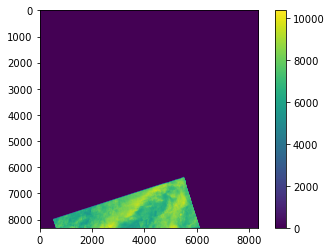

20200330_172422_1_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1485, 3338)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172422_1_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172422_1_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 0.0


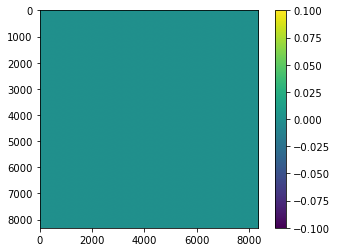

20200320_201514_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4495, 9040)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200320_201514_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200320_201514_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18933.63866740875


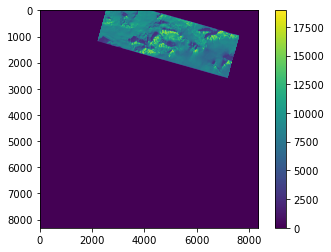

20200322_192820_61_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7501, 3779)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_192820_61_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_192820_61_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18131.64897474931


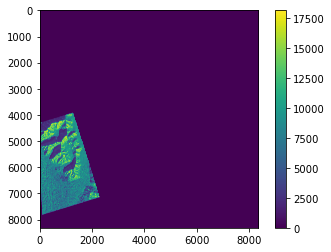

20200312_201224_101f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5033, 7401)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201224_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201224_101f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20062.310844210355


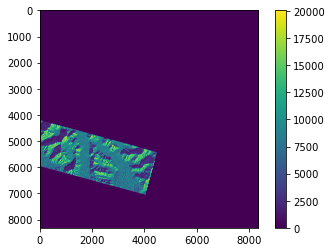

20200323_173025_0f49_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3268, 3558)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200323_173025_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200323_173025_0f49_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19395.44913034582


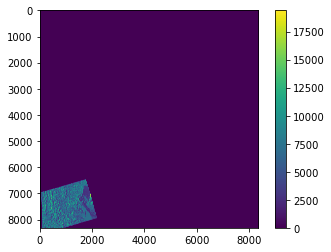

20200322_192822_72_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7852, 2341)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_192822_72_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_192822_72_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18408.773846408025


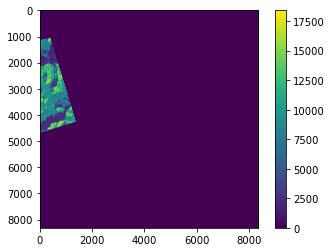

20200323_173027_0f49_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4715, 2366)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200323_173027_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200323_173027_0f49_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23585.684378960334


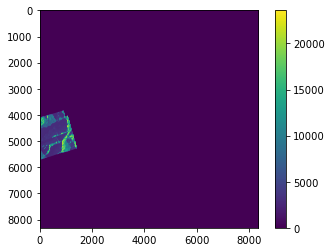

20200329_201724_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4671, 9100)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_201724_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_201724_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16500.621097885105


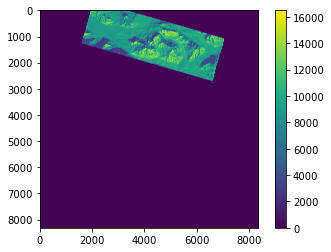

20200330_201436_0f25_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1101, 526)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_201436_0f25_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_201436_0f25_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 0.0


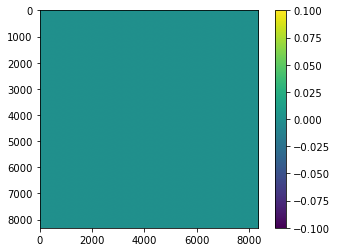

20200302_192329_49_106b_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6368, 6931)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_192329_49_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_192329_49_106b_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11843.927135114602


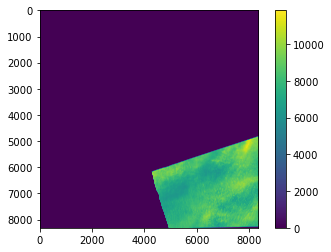

20200317_201845_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3899, 2526)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200317_201845_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200317_201845_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18367.430433415673


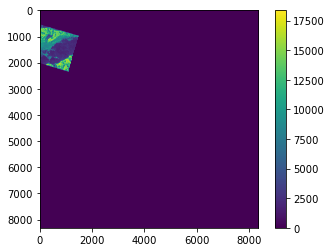

20200303_204233_02_1058_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7791, 4067)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_204233_02_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_204233_02_1058_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 25945.311247167378


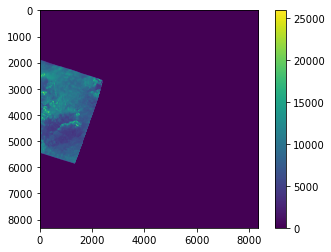

20200316_192435_74_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5910, 7972)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_192435_74_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_192435_74_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 9352.044786896377


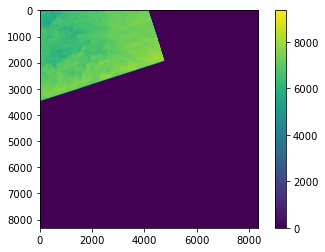

20200325_193025_42_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1714, 4702)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_193025_42_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_193025_42_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8863.331694435003


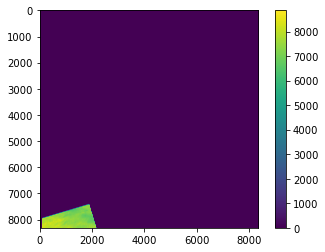

20200326_172804_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4882, 6913)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172804_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172804_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20487.119026891698


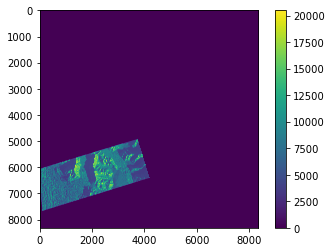

20200323_173024_0f49_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (1069, 4170)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200323_173024_0f49_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200323_173024_0f49_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17502.28352649496


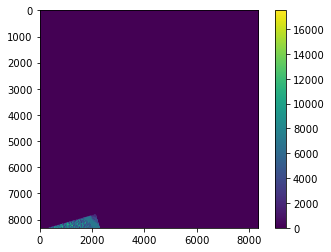

20200320_201429_103e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (371, 2164)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200320_201429_103e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200320_201429_103e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11116.318919516934


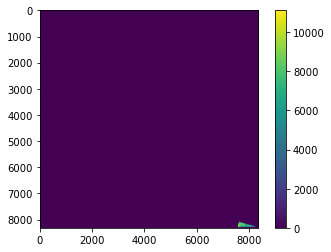

20200305_192540_56_106f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8192, 5392)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200305_192540_56_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200305_192540_56_106f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 27153.80001961937


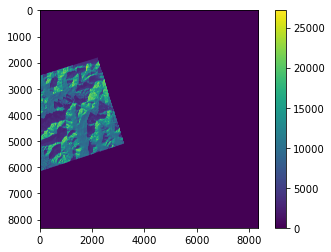

20200320_201515_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5005, 9014)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200320_201515_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200320_201515_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22229.78392551838


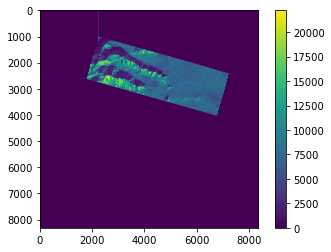

20200329_172822_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4821, 4006)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172822_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172822_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17876.404693098466


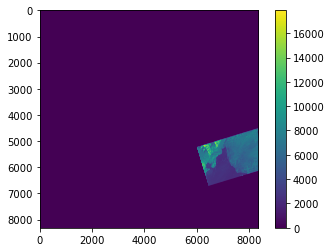

20200326_201845_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3193, 8415)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201845_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201845_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12053.00488458425


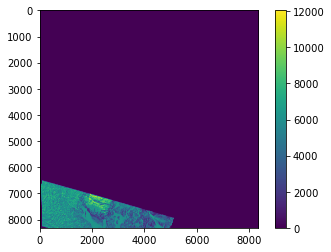

20200322_204116_11_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2736, 9158)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_204116_11_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_204116_11_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18037.139691982455


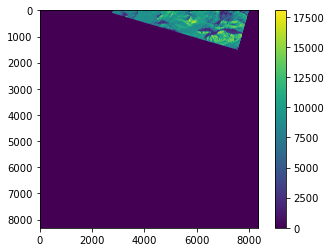

20200308_203629_15_105e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4289, 7556)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200308_203629_15_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200308_203629_15_105e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10560.442957382484


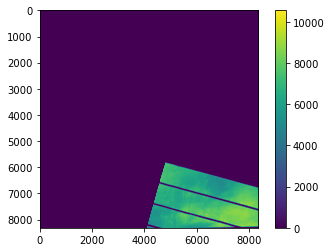

20200308_203625_05_105e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7647, 4837)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200308_203625_05_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200308_203625_05_105e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15675.339925150163


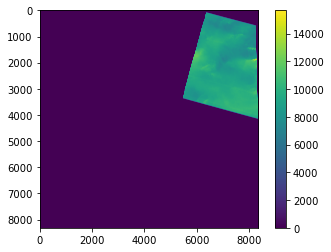

20200312_192203_93_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8196, 5032)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_192203_93_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_192203_93_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21862.13539184182


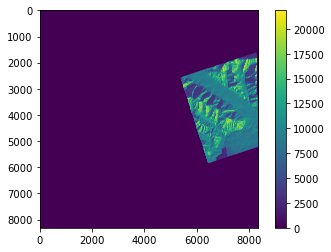

20200301_192302_09_106f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5318, 3635)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200301_192302_09_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200301_192302_09_106f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15683.478684525742


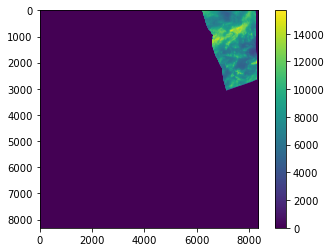

20200315_192403_61_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5126, 9836)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_192403_61_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_192403_61_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20317.19206652651


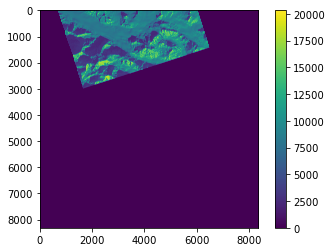

20200330_172423_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4972, 4710)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172423_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172423_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22794.68583233883


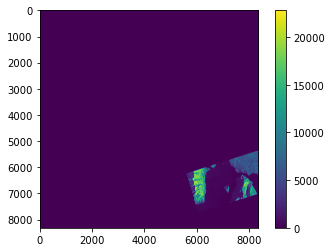

20200329_201726_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5068, 9085)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_201726_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_201726_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16592.325388876037


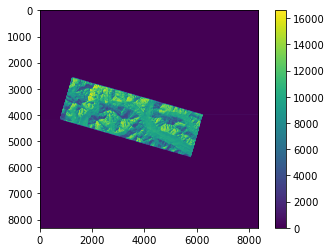

20200311_192917_42_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7287, 4829)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200311_192917_42_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200311_192917_42_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22644.47515655618


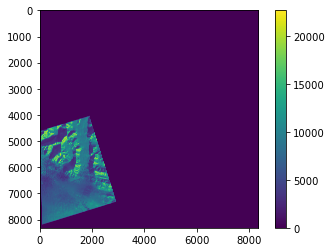

20200322_192818_51_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2717, 5183)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_192818_51_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_192818_51_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17438.614755817147


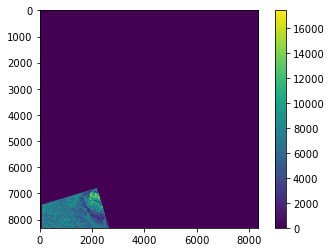

20200326_172805_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4890, 6261)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172805_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172805_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19317.770063088334


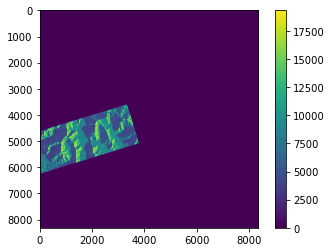

20200329_172822_1_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4834, 4608)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172822_1_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172822_1_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19866.575153794183


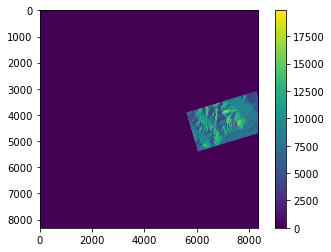

20200320_201426_103e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5088, 131)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200320_201426_103e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200320_201426_103e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8632.894122506266


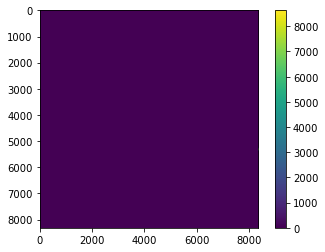

20200326_201840_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4093, 9060)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201840_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201840_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15352.577030480257


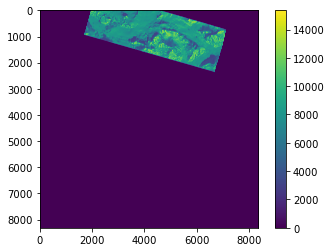

20200330_172425_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5000, 6003)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172425_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172425_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21998.165590098677


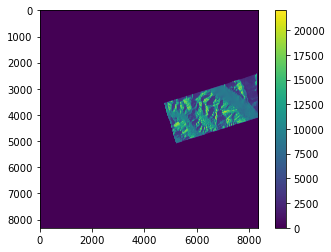

20200325_200932_100a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4930, 2874)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_200932_100a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_200932_100a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17047.147902383866


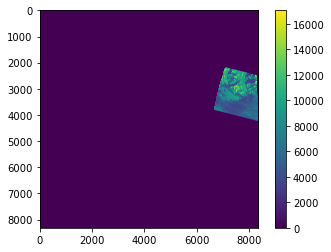

20200316_192431_56_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6655, 9842)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_192431_56_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_192431_56_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10228.227334372965


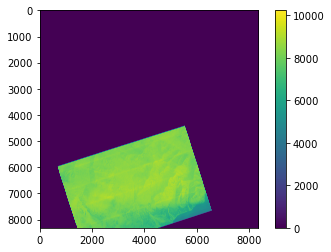

20200330_172424_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4963, 5372)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172424_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172424_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20371.524876313873


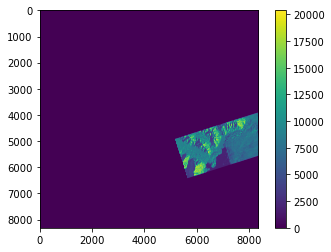

20200304_203525_05_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6075, 7575)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_203525_05_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_203525_05_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12635.242347574089


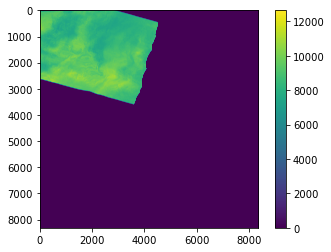

20200304_192442_48_1068_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8269, 7968)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_192442_48_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_192442_48_1068_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14782.274949416911


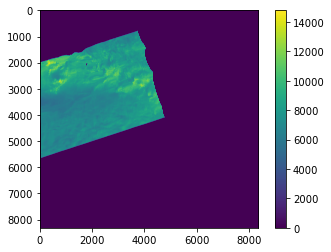

20200312_201601_1003_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5149, 6958)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201601_1003_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201601_1003_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21402.018967988963


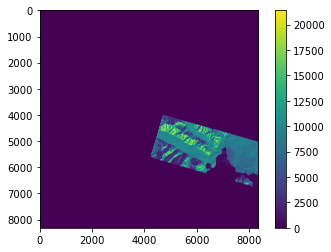

20200329_172824_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4785, 5811)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172824_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172824_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23529.89427458574


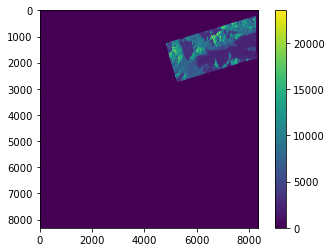

20200329_172825_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2571, 6419)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172825_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172825_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 24030.93203362675


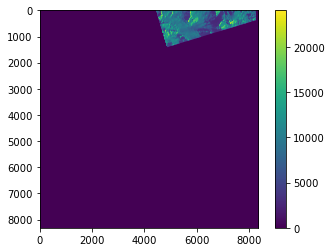

20200326_201145_1006_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3394, 5568)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201145_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201145_1006_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14303.221525252025


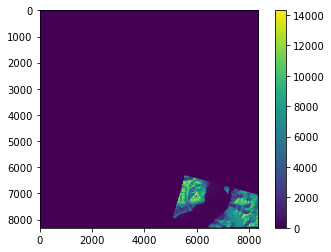

20200329_201728_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4963, 8888)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_201728_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_201728_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15547.31154490382


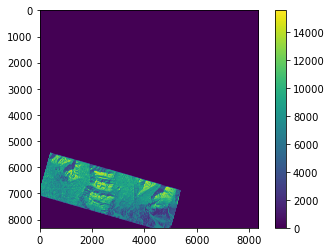

20200303_192412_27_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4700, 9780)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_192412_27_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_192412_27_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14110.750168446983


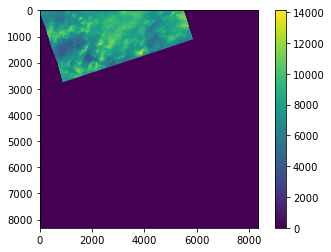

20200326_172807_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4877, 5008)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172807_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172807_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23028.579095648547


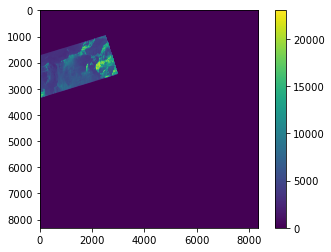

20200325_193027_52_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6487, 3284)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_193027_52_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_193027_52_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8992.099044868673


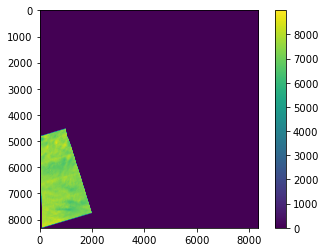

20200326_201842_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5043, 9049)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201842_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201842_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15451.278761927


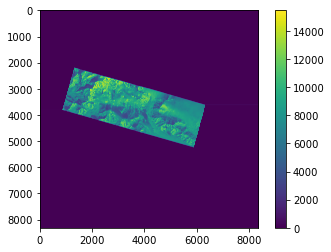

20200325_201754_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5162, 6252)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200325_201754_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200325_201754_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19832.960875348526


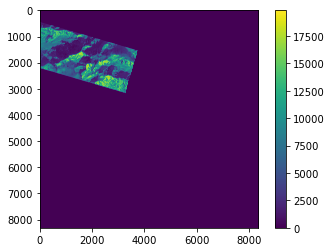

20200330_172426_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4945, 6592)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172426_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172426_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23237.893132962396


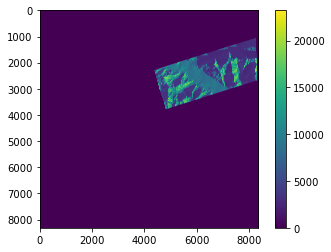

20200329_172821_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4833, 3394)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172821_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172821_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16310.627549011911


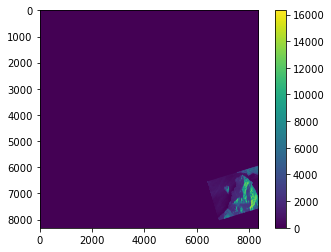

20200303_204230_98_1058_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5034, 4855)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_204230_98_1058_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_204230_98_1058_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 28779.05648564223


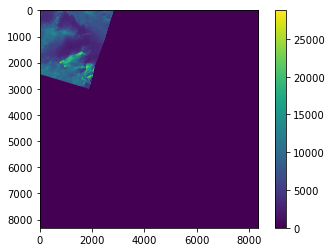

20200313_192304_64_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6711, 6588)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200313_192304_64_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200313_192304_64_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 8706.72526397452


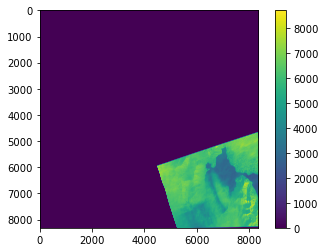

20200313_203933_42_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7595, 6133)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200313_203933_42_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200313_203933_42_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 52767.8506066268


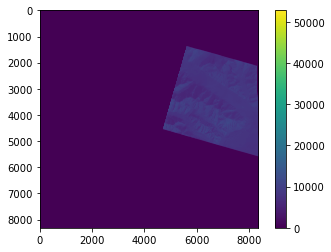

20200304_203527_08_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7506, 6210)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_203527_08_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_203527_08_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12935.652396045254


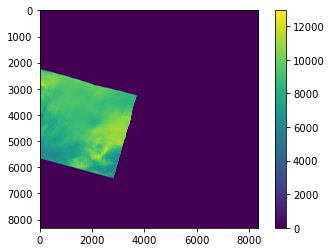

20200326_201841_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5042, 9040)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201841_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201841_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17519.15272501245


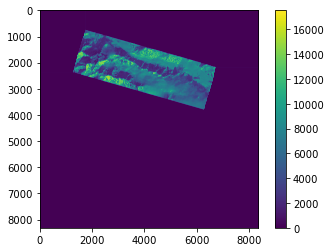

20200318_192554_74_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6431, 7244)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200318_192554_74_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200318_192554_74_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 14778.321394163659


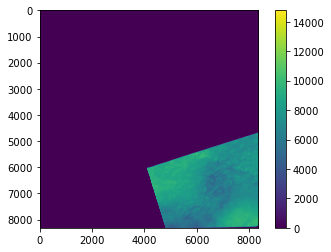

20200330_172427_104a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4292, 7242)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_172427_104a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_172427_104a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23030.222834384273


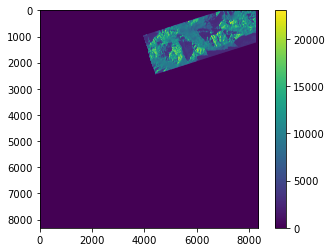

20200326_201144_1006_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4980, 4879)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201144_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201144_1006_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 13671.68138460904


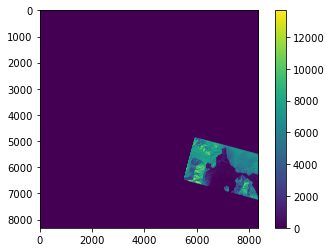

20200319_192628_52_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7929, 6495)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200319_192628_52_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200319_192628_52_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18409.51344124964


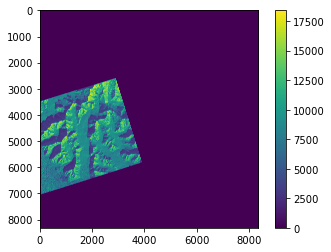

20200318_192558_94_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6062, 9598)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200318_192558_94_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200318_192558_94_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15149.642043952106


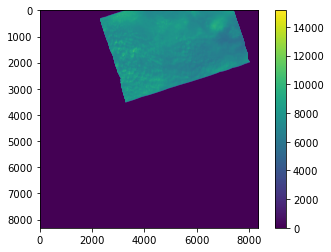

20200326_201140_1006_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4950, 2736)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201140_1006_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201140_1006_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18168.826509170067


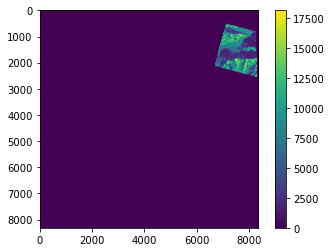

20200312_192206_01_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5231, 6459)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_192206_01_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_192206_01_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21897.19063216705


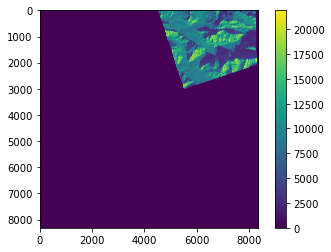

20200312_201223_101f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5026, 8081)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_201223_101f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_201223_101f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20329.391164060056


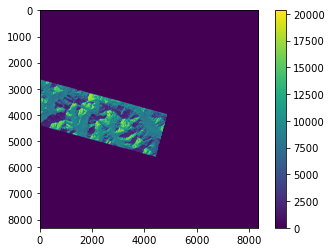

20200329_201725_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5069, 9091)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_201725_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_201725_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18938.07455280809


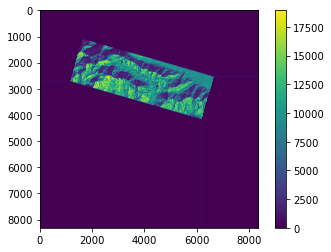

20200329_172823_0f33_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4830, 5221)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_172823_0f33_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_172823_0f33_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 22166.40104571825


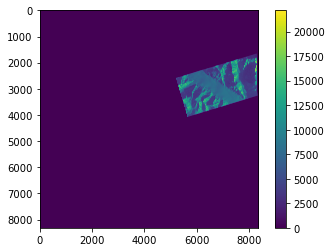

20200326_201844_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5113, 9059)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201844_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201844_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12599.31236558288


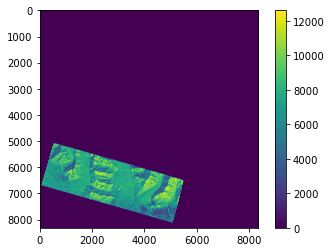

20200328_203758_89_105d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7574, 7722)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200328_203758_89_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200328_203758_89_105d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17207.801747970407


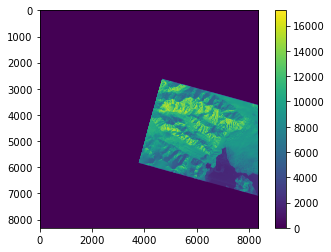

20200313_192306_73_106e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8183, 8058)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200313_192306_73_106e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200313_192306_73_106e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15150.131884995968


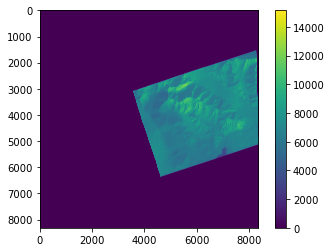

20200316_172911_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4854, 6495)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172911_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172911_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16241.624120687928


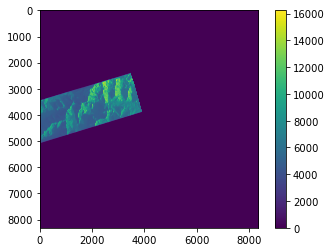

20200316_192433_65_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8033, 9437)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_192433_65_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_192433_65_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 9784.850878764308


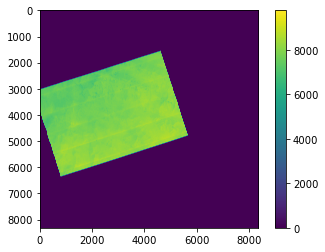

20200326_172806_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4882, 5618)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172806_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172806_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23535.78098315715


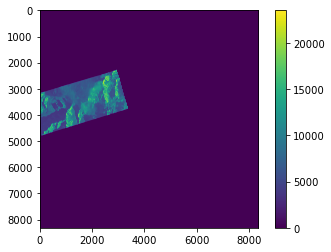

20200302_204101_19_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6180, 9557)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_204101_19_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_204101_19_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 49824.85907362869


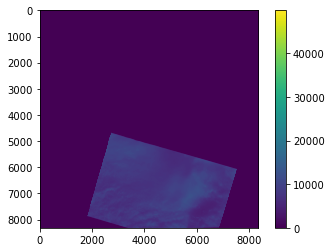

20200329_201727_1027_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5075, 9082)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200329_201727_1027_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200329_201727_1027_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16199.586544481746


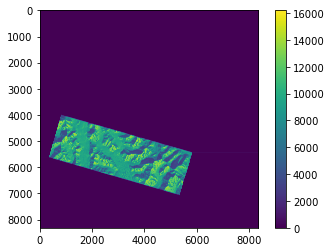

20200302_204057_09_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6159, 8208)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_204057_09_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_204057_09_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 44996.30757261394


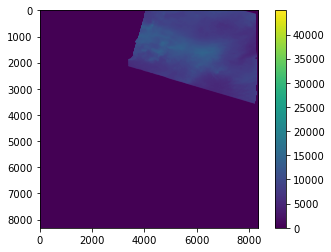

20200304_192440_43_1068_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8057, 9362)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200304_192440_43_1068_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200304_192440_43_1068_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 10738.834847646143


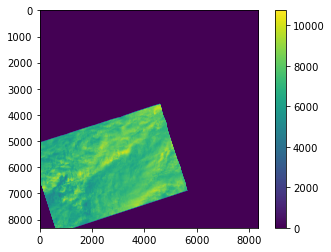

20200328_203756_85_105d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7381, 6315)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200328_203756_85_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200328_203756_85_105d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15872.707153952191


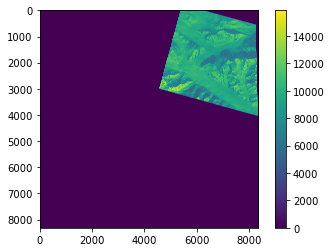

20200302_204059_14_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7639, 9466)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_204059_14_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_204059_14_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 59351.65299748041


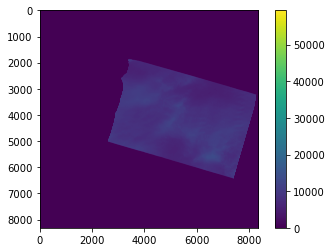

20200306_192610_56_106b_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8132, 9969)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200306_192610_56_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200306_192610_56_106b_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 24326.723713698553


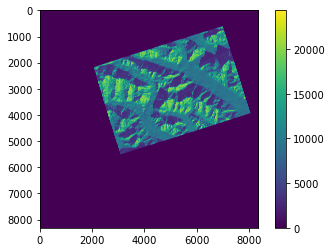

20200305_192538_50_106f_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6308, 6816)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200305_192538_50_106f_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200305_192538_50_106f_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23891.42117899068


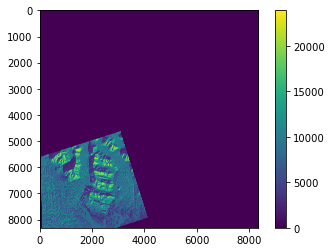

20200326_201843_103d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5043, 9085)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_201843_103d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_201843_103d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 13756.267888196544


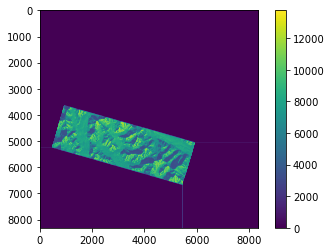

20200302_192331_54_106b_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8334, 8439)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_192331_54_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_192331_54_106b_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12925.19826993561


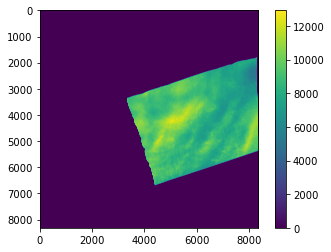

20200303_192408_19_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8272, 10026)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_192408_19_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_192408_19_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23452.822952197483


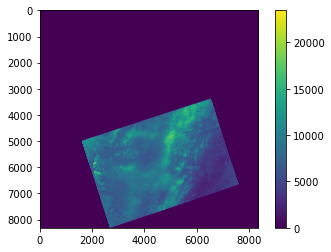

20200316_172908_0f32_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3446, 8368)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_172908_0f32_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_172908_0f32_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 13556.297644470656


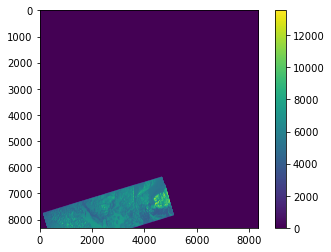

20200308_203627_10_105e_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7590, 6212)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200308_203627_10_105e_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200308_203627_10_105e_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 11473.335231617355


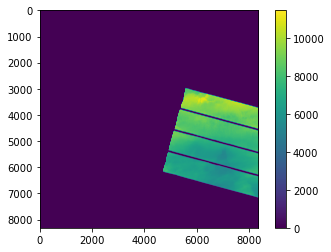

20200319_192626_46_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4994, 7909)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200319_192626_46_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200319_192626_46_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16840.18477099883


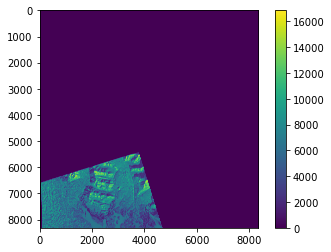

20200328_203754_82_105d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2694, 4929)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200328_203754_82_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200328_203754_82_105d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12883.066483738014


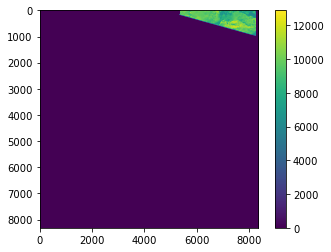

20200303_192410_23_106c_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8189, 10010)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200303_192410_23_106c_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200303_192410_23_106c_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17239.449395497657


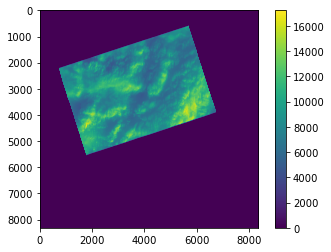

20200312_192159_76_1063_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (2754, 2023)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200312_192159_76_1063_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200312_192159_76_1063_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21154.06685538449


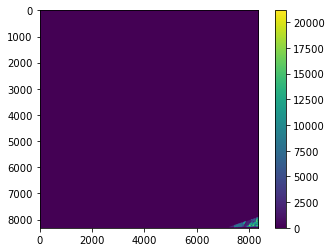

20200306_192608_50_106b_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (8227, 9164)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200306_192608_50_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200306_192608_50_106b_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 23417.308611238106


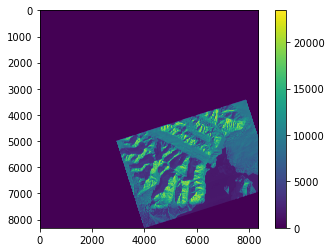

20200316_203620_90_1059_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7558, 9488)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_203620_90_1059_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_203620_90_1059_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15881.019312461067


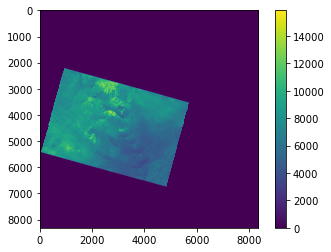

20200319_192630_59_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7485, 5072)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200319_192630_59_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200319_192630_59_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19020.480480979902


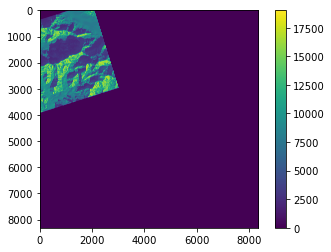

20200322_204122_23_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5065, 9563)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_204122_23_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_204122_23_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17828.02487412


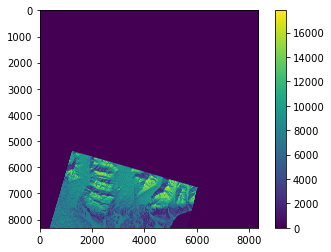

20200330_192456_86_1065_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6602, 7310)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_192456_86_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_192456_86_1065_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17101.04441519982


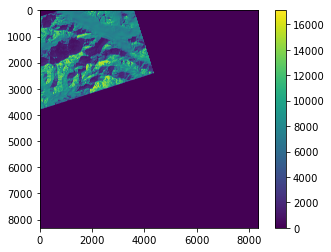

20200318_192556_84_106a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7890, 8660)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200318_192556_84_106a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200318_192556_84_106a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 15468.467935607267


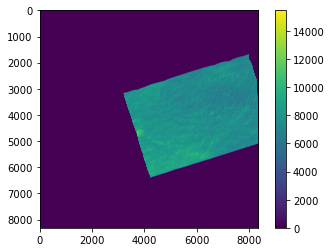

20200330_192454_76_1065_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7918, 8766)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_192454_76_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_192454_76_1065_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16654.362056478545


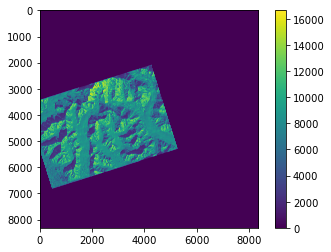

20200326_172803_0f36_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (3630, 7539)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200326_172803_0f36_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200326_172803_0f36_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19094.91220397434


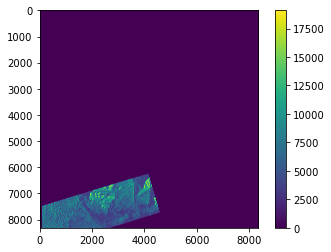

20200322_204118_15_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7418, 9580)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_204118_15_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_204118_15_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18320.029534955967


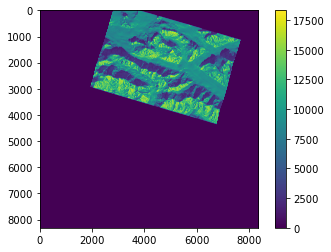

20200322_204120_19_1064_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7636, 9523)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200322_204120_19_1064_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200322_204120_19_1064_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 18355.597773960053


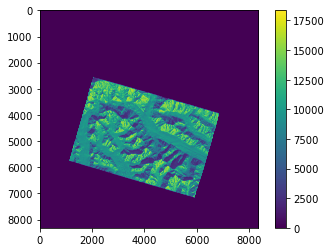

20200306_204117_75_105d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6416, 9008)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200306_204117_75_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200306_204117_75_105d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 21821.77764977894


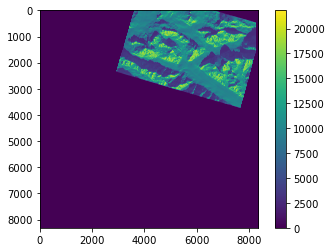

20200313_203935_49_105a_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6880, 7586)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200313_203935_49_105a_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200313_203935_49_105a_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 48105.3627201525


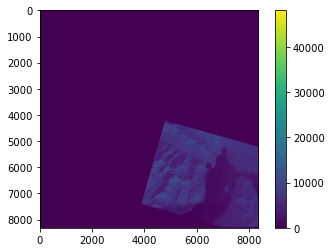

20200315_192401_56_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7981, 9774)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_192401_56_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_192401_56_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 20451.048972367123


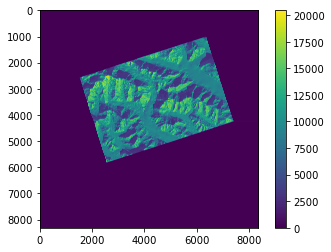

20200328_203800_93_105d_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (4892, 9071)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200328_203800_93_105d_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200328_203800_93_105d_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 17367.22560687938


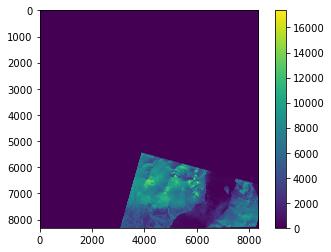

20200316_203622_95_1059_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5621, 8173)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200316_203622_95_1059_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200316_203622_95_1059_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 13830.399892783127


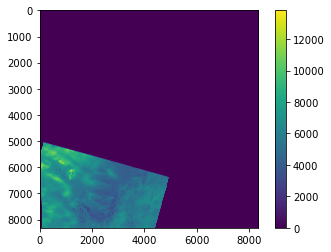

20200330_192452_66_1065_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (5743, 9701)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200330_192452_66_1065_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200330_192452_66_1065_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 16029.38496703934


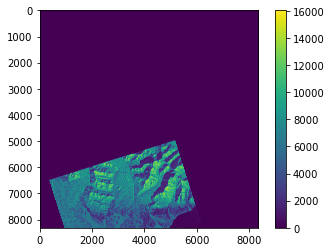

20200302_192333_60_106b_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (6650, 9863)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200302_192333_60_106b_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200302_192333_60_106b_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 12890.72728906384


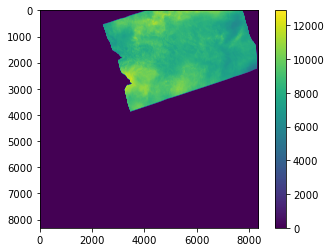

20200315_192359_50_1069_3B_AnalyticMS_SR_harmonized_clip.tif
32607
EPSG:32607
4
Image dimensions: (7609, 9839)
Resample to DSM dimensions: (8317, 8360)
Save resampled image to 20200315_192359_50_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif
20200315_192359_50_1069_3B_AnalyticMS_SR_harmonized_clip.tif resampled
0.0 19016.47166023776


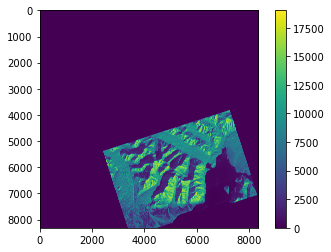

All images resampled.
outpath /Volumes/LaCie/PS_downloads_SK/download/PSScene/standard_grid/
outfile 20200315_192359_50_1069_3B_AnalyticMS_SR_harmonized_clip_5m.tif


In [23]:
imgpath = '/Volumes/LaCie/PS_downloads_SK/download/PSScene/' # enter path to folder with all the images to resample
outpath = '/Volumes/LaCie/PS_downloads_SK/download/PSScene/standard_grid/' # output files
if not os.path.exists(outpath):
    os.mkdir(outpath)
    
    
for imgname in os.listdir(imgpath): # loop through all images
    if imgname.endswith("SR_harmonized_clip.tif"): # some sort of condition to make sure the correct tif file is grabbed
        print(imgname)
        
        # create folder to hold reprojected images
        if not os.path.exists(imgpath + 'reprojected/'):
            os.mkdir(imgpath + 'reprojected/')
        
        # grab the CRS for the image and the DEM
        raster = gdal.Open(imgpath + imgname)
        projstg = raster.GetProjection()
        imgcrs = projstg.split('EPSG')[-1][3:8]
        print(imgcrs)
        print(dsm.crs)
        # if they aren't equal, then reproject and copy
        if 'EPSG:' + imgcrs != str(dsm.crs):
            gdal.Warp(imgpath + 'reprojected/' + imgname, imgpath + imgname, dstSRS=str(dsm.crs))
            print('reprojecting' + imgname)
        else:
            # otherwise just copy
            shutil.copy(imgpath + imgname, imgpath + 'reprojected/'+ imgname)
    
        # open the reprojected image
        img = rio.open(imgpath + 'reprojected/'+ imgname) # open using rasterio
        img_data = img.read() # grab the NIR band, 4
        # select band
        print(len(img_data))
        if len(img_data) == 4:
            nir = img_data[3]
        elif len(img_data) == 1:
            nir = img_data[0]

        print("Image dimensions:",nir.shape)
        # grab the x and y grid values for the DSM
        img_x = np.linspace(img.bounds.left, img.bounds.right, num=np.shape(nir)[1])
        img_y = np.linspace(img.bounds.top, img.bounds.bottom, num=np.shape(nir)[0])
        
        # resample
        f = interp2d(img_x, img_y, nir) # create img interpolation object
        nir_resamp = np.zeros(np.shape(elev)) # initialize resampled image with DSM shape
        nir_resamp = f(dsm_x,dsm_y) # resample the NIR data to the DSM coordinates
        nir_resamp = np.flipud(nir_resamp) # flip up down
        print("Resample to DSM dimensions:",elev.shape)
        
        # remove empty files
#         if np.nanmax(nir_resamp) == np.nanmin(nir_resamp):
#             dsrt = imgname[:-26]
#             print(dsrt)
#             os.remove(imgpath + imgname) # this removes the SR_clip.tif
#             os.remove(imgpath + dsrt + '_3B_AnalyticMS_DN_udm_clip.tif')
#             os.remove(imgpath + dsrt + '_3B_AnalyticMS_metadata_clip.xml')
#             os.remove(imgpath + dsrt + '_metadata.json')
#             print(dsrt + ' deleted')
        
#         else:
        if True:
            # save the resampled image to georeferenced tif file
            outfile = imgname[:-4]+'_'+str(round(dsm_resolution))+'m.tif' # generate new filename with 5m suffix
            print("Save resampled image to", outfile)
            with rio.open(outpath+outfile,'w',
                                driver='GTiff',
                                height=nir_resamp.shape[0],
                                width=nir_resamp.shape[1],
                                dtype=nir_resamp.dtype,
                                count=1,
                                crs=dsm.crs,
                                transform=dsm.transform) as dst:
                    dst.write(nir_resamp, 1)
            print(imgname + ' resampled')
            print(np.nanmin(nir_resamp), np.nanmax(nir_resamp))
            
            plt.imshow(nir_resamp)
            plt.colorbar()
            plt.show()
            
print("All images resampled.")

print("outpath", outpath)
print("outfile", outfile)

